In [2]:
!pip install tensorflow-quantum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.5 MB 13.2 MB/s 
     |████████████████████████████████| 541 kB 49.0 MB/s 
     |████████████████████████████████| 90 kB 9.5 MB/s 
     |████████████████████████████████| 90 kB 9.8 MB/s 
     |████████████████████████████████| 1.8 MB 37.7 MB/s 
     |████████████████████████████████| 6.1 MB 19.6 MB/s 
     |████████████████████████████████| 100 kB 9.1 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 93 kB 1.8 MB/s 
     |████████████████████████████████| 93 kB 1.9 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 92 kB 1.3 M

In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np


import pandas as pd
import math

import warnings

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [15]:
def circuit_builder(n_qubits, n_pqc_layers, tag=''):
  
  assert n_qubits>1, "in order to achieve entanglement, please build the circuit with at least 2 qubits"
  qbs=cirq.LineQubit.range(n_qubits)
  ops=[cirq.Z(qbs[qb]) for qb in range(n_qubits)]

  #define the symmbols for the encoding 
  enc_string=''
  for q in range(n_qubits):
    usage='ENC'
    space=' '
    enc_string+=tag+usage+'Qub'+str(q)+space

  enc_symbols = sympy.symbols(enc_string)

  #define the symmbols for the pqc
  layers=[str(i) for i in range(n_pqc_layers)]
  rotations=['Z','Y','X']
  layers_list=[]
  usage='PQC'
  l_symbols=[]
  for layer in layers:
    l_layer=[]
    for q in range(n_qubits):
      l_qub=[]
      for rot in rotations:
        symb = tag+usage+'Layer'+layer+'Qub'+str(q)+'Rot'+rot
        l_qub.append(symb)
      l_layer.append(l_qub)
    l_symbols.append(l_layer)
  pqc_symbols=sympy.symbols(l_symbols)
  
  #create istance of the circuit and append rotations for encoding with enc_symbols as parameters
  circuit = cirq.Circuit()
  circuit.append([cirq.rx(enc_symbols[qb]).on(qbs[qb]) for qb in range(n_qubits)])

  #append pqc layers
  for layer in range(n_pqc_layers):
    for rot in rotations:
      if rot=='Z':
        circuit.append(cirq.Moment([
                        cirq.rz(pqc_symbols[layer][qb][0]).on(qbs[qb]) for qb in range(n_qubits)])
                    )
      elif rot=='Y':
        circuit.append(cirq.Moment([
                        cirq.ry(pqc_symbols[layer][qb][1]).on(qbs[qb]) for qb in range(n_qubits)])
                    )
      elif rot=='X':
        circuit.append(cirq.Moment([
                        cirq.rx(pqc_symbols[layer][qb][2]).on(qbs[qb]) for qb in range(n_qubits)])
                    )


    for qb in range(n_qubits-1):
      circuit.append(cirq.Moment([
                        cirq.CNOT(qbs[qb],qbs[qb+1]) ])
                    )
    if (n_qubits != 2):
      circuit.append( cirq.Moment([
                                   cirq.CNOT(qbs[n_qubits-1],qbs[0]) ])
                      )
  pqc_symbols=[symb for lay_list in pqc_symbols for qub_list in lay_list for symb in qub_list]
  circuit_spec={"enc_symb":list(enc_symbols) ,"pqc_symb":pqc_symbols, "ops": ops, "n_qubits":n_qubits,  "n_pqc_layers":n_pqc_layers}

  return circuit, circuit_spec



class QuantumLayer2D(tf.keras.layers.Layer):

  def __init__(self, circuit, circuit_spec, len_seq, max_batch_size=64, name='quantum_layer_2d'):
  
    super(QuantumLayer2D,self).__init__()

    self.len_seq = len_seq
    self.circuit=circuit
    self.n_qubits=circuit_spec["n_qubits"]
    self.enc_symbols = circuit_spec["enc_symb"]
    self.pqc_symbols = circuit_spec["pqc_symb"]
    self.all_symbols = self.enc_symbols + self.pqc_symbols
    self.ops = circuit_spec["ops"]
    self.max_batch_size=max_batch_size
    self.len_seq = len_seq
    
    init=tf.random_normal_initializer()
    self.pqc_params=tf.Variable(initial_value=init(shape=(1,len(self.pqc_symbols)), 
                                                        dtype="float32"),trainable=True)
    
    self.expect_layer=tfq.layers.Expectation()

    self.tens_circuit=tfq.convert_to_tensor([self.circuit for _ in range(self.max_batch_size)])

    warnings.warn(
    f"\nNOTE: You are using an istance of the QuantumLayer2D class."
    f"\nThe maximum batch size dimension allowed in training/predicting for a model containing a "
    f"QuantumLayer2D is {self.max_batch_size}."
    
    f"\nWhen predicting outputs, please call the method call_in_batches of the model with a"
    f" batch_size value less than or equal to {self.max_batch_size}."

    f"\nIf default call method is used when predicting and the batch size of the datas "
    f"is greater than {self.max_batch_size}, an Error will be raised."

    f"\nIf a bigger batch size is desired, please consider to increase the value of "
    f"max_batch_size arg in your QuantumLayer2D: {name}.")

  def call(self, inputs, training):

    # inputs: classical output of a previous layer (i.e. classical data to encode)
    # or directly the classical input for the model

    
    batch_size = tf.shape(inputs)[0]
    pqc_params=tf.reshape(self.pqc_params, shape=(1,1,-1))
    pqc_params=tf.tile(pqc_params, [batch_size,self.len_seq, 1])
    joined_params =  tf.concat([inputs, pqc_params], -1)
    
    
    expectations=tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for t in range(self.len_seq): 
      expect_t = self.expect_layer(self.tens_circuit[:batch_size],
                                      operators=self.ops,
                                      symbol_names= self.all_symbols,
                                      symbol_values = joined_params[:,t,:])
      expectations =expectations.write(t, expect_t)

    return tf.reshape(expectations.stack(),(batch_size,self.len_seq,self.n_qubits))


    
class PositionalEncoder:
    
    def __init__(self):
        pass

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self,position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def encode(self,x):
        
        _, len_seq, d_model = x.shape
        pos_enc=self.positional_encoding(len_seq, d_model)
        
        return pos_enc + x


    

class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self,*, d_attention, num_heads, input_dim):
        
        super(MultiHeadAttention,self).__init__()
        self.num_heads=num_heads
        self.d_attention=d_attention
        
        init = tf.random_normal_initializer()
        self.q_weights = tf.Variable(initial_value=init(shape=(num_heads, input_dim, d_attention), 
                                                        dtype="float32"),trainable=True)
        self.k_weights = tf.Variable(initial_value=init(shape=(num_heads, input_dim, d_attention), 
                                                        dtype="float32"),trainable=True)
        self.v_weights = tf.Variable(initial_value=init(shape=(num_heads, input_dim, d_attention), 
                                                        dtype="float32"),trainable=True)
        
        self.dense = tf.keras.layers.Dense(input_dim)
        
    def call(self,q,k,v, apply_look_ahead_mask, MASK):
        
        len_q = q.shape[1]
        
        q = tf.matmul(tf.stack([q]*self.num_heads,axis=1),self.q_weights)
        k = tf.matmul(tf.stack([k]*self.num_heads,axis=1),self.k_weights)
        v = tf.matmul(tf.stack([v]*self.num_heads,axis=1),self.v_weights)
        
        #multiply q and k and divide by sqrt(d_attention)
        attention_logits = tf.matmul(q, k, transpose_b=True)/tf.math.sqrt(tf.cast(self.d_attention, tf.float32))
        
        if MASK is not None:
            attention_logits = tf.math.add(attention_logits,MASK)
        
        if apply_look_ahead_mask:
            attention_logits=self.look_ahead_mask(attention_logits)
        
        #softmax
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)
        
        #multiply weights and v
        attention = tf.matmul(attention_logits, v) #(batch_size, num_heads, len_q, d_attention)
        
        #concatenate
        conc_attention = tf.reshape(attention, shape=(-1,len_q,self.d_attention*self.num_heads))
    
        #pass trough last linear layer
        attention_output = self.dense(conc_attention)
        
        return attention_output
    
    def add_look_ahead_mask(self,x): 

        len_q, len_k = x.shape[-2:]

        mask = 1 - tf.linalg.band_part(tf.ones((len_q, len_k)), -1, 0)
        mask*= -1e9

        return tf.math.add(x,mask) #(batch_size, num_heads, len_q, len_k)




class EncoderLayer(tf.keras.layers.Layer):
    
    def __init__(self, *, d_attention, num_heads, input_dim, dff, dropout_rate):
        
        super(EncoderLayer, self).__init__()
        
        #multihead attention sublayer
        self.mha = MultiHeadAttention(d_attention=d_attention, 
                                      num_heads=num_heads, 
                                      input_dim=input_dim)
        
        #ffw neural network sublayer
        self.ffn = tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  
                tf.keras.layers.Dense(input_dim)  
                ])
        
        #normalization sublayers
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        #dropout sublayers(optional)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, MASK):
        
        mha_output = self.mha(x, x, x, apply_look_ahead_mask=False, MASK=MASK)  #mask argument is in call method of MHA
        mha_output = self.dropout1(mha_output, training=training)
        out1 = self.layernorm1(x + mha_output)  

        ffn_output = self.ffn(out1)  
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  

        return out2



    
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, *, num_layers, d_attention, num_heads, len_seq, input_dim, dff, dim_filter, dropout_rate, masking, resfilter):
        super(Encoder, self).__init__()
        
        if resfilter:
            if dim_filter==None:
              dim_filter=dff
            self.filter = tf.keras.Sequential([
                tf.keras.layers.Dense(dim_filter, activation='relu'),  
                tf.keras.layers.Dense(input_dim)  
                ])
        
        self.num_layers = num_layers
        self.pos_encoder = PositionalEncoder()
        self.masking=masking
        self.resfilter=resfilter
            
        self.enc_layers = [
            
            EncoderLayer(d_attention=d_attention, 
                         num_heads=num_heads,  
                         input_dim=input_dim, 
                         dff=dff,  
                         dropout_rate=dropout_rate) for i in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training):
        
        masks = [None for i in range(self.num_layers)]
        #first, eventually create the mask
        if self.masking:
            MASK=self.create_missing_timesteps_mask(x,x)
            masks[0] =MASK #we mask, eventually, only on the first encoder layer
                
        #then, eventually apply the mixing layer and create the res connection with the input, also adding positional encoder
        #or just apply pos encoder if mixing is false

        
        if self.resfilter:
            x_filtered = self.filter(x)
            x += x_filtered
        x = self.pos_encoder.encode(x)   
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, masks[i])

        return x  
    
    def create_missing_timesteps_mask(self,q,k):

        len_q = q.shape[1]
        len_k = k.shape[1]
        
        mask_value=0.

        query_mask_trigger = tf.cast(tf.reduce_any(q != mask_value, axis=2),'float32')
        key_mask_trigger = tf.cast(tf.reduce_any(k != mask_value, axis=2),'float32')
        
        query_mask_trigger = tf.reshape(query_mask_trigger, (-1,len_q,1))
        key_mask_trigger = tf.reshape(key_mask_trigger, (-1,1,len_k))
        
        MASK=tf.reshape((tf.matmul(query_mask_trigger,key_mask_trigger)-1)*1e9,shape=(-1,1,len_q,len_k))
        return MASK



    
class Encoder_Only_Transformer(tf.keras.Model):
    
    def __init__(self,*, num_layers, d_attention, num_heads, len_seq, input_dim, dff, dim_filter=None, dropout_rate=0.1, masking=False, resfilter):
        
        super(Encoder_Only_Transformer,self).__init__()
        
        self.encoder = Encoder(num_layers=num_layers, 
                               d_attention=d_attention, 
                               num_heads=num_heads, 
                               input_dim=input_dim, 
                               len_seq=len_seq,
                               dff=dff, 
                               dim_filter=dim_filter,
                               dropout_rate=dropout_rate,
                               masking=masking,
                               resfilter=resfilter)

        self.flatten = tf.keras.layers.Flatten()
        self.dense= tf.keras.layers.Dense(64,activation='relu')
        self.dense2=tf.keras.layers.Dense(16, activation='relu')
        self.dense_out=tf.keras.layers.Dense(1,activation='linear')
        

    def call(self, inp, training):
        
        
        out = self.encoder(inp, training) 
        out = self.flatten(out)
        out = self.dense(out)
        out = self.dense2(out)
        out = self.dense_out(out)
        
        return out



class QEncoder(tf.keras.layers.Layer):
    
    def __init__(self, *, num_layers, d_attention, num_heads, len_seq, input_dim, dff, dropout_rate, masking, qresfilter, qubits, pqc_layers):
        super(QEncoder, self).__init__()
        
        

        if qresfilter:
          if qubits==0:
            circuit, circuit_spec = circuit_builder(input_dim,pqc_layers)
            self.qfilter = QuantumLayer2D(circuit,circuit_spec,len_seq)
          else:
            circuit, circuit_spec = circuit_builder(qubits,pqc_layers)
            self.qfilter = tf.keras.Sequential([
                tf.keras.layers.Dense(qubits, activation='relu'),  
                QuantumLayer2D(circuit,circuit_spec,len_seq),
                tf.keras.layers.Dense(input_dim)
                ])
            
        self.num_layers = num_layers
        self.pos_encoder = PositionalEncoder()
        self.masking=masking
        self.qresfilter=qresfilter
            
        self.enc_layers = [
            
            EncoderLayer(d_attention=d_attention, 
                         num_heads=num_heads,  
                         input_dim=input_dim, 
                         dff=dff,  
                         dropout_rate=dropout_rate) for i in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training):
        
        masks = [None for i in range(self.num_layers)]
        #first, eventually create the mask
        if self.masking:
            MASK=self.create_missing_timesteps_mask(x,x)
            masks[0] =MASK #we mask, eventually, only on the first encoder layer
                
        #then, eventually apply the mixing layer and create the res connection with the input, also adding positional encoder
        #or just apply pos encoder if mixing is false

        
        if self.qresfilter:
            x_filtered = self.qfilter(x)
            x += x_filtered
        x = self.pos_encoder.encode(x)   
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, masks[i])

        return x  
    
    def create_missing_timesteps_mask(self,q,k):

        len_q = q.shape[1]
        len_k = k.shape[1]
        
        mask_value=0.

        query_mask_trigger = tf.cast(tf.reduce_any(q != mask_value, axis=2),'float32')
        key_mask_trigger = tf.cast(tf.reduce_any(k != mask_value, axis=2),'float32')
        
        query_mask_trigger = tf.reshape(query_mask_trigger, (-1,len_q,1))
        key_mask_trigger = tf.reshape(key_mask_trigger, (-1,1,len_k))
        
        MASK=tf.reshape((tf.matmul(query_mask_trigger,key_mask_trigger)-1)*1e9,shape=(-1,1,len_q,len_k))
        return MASK



    
class QEncoder_Only_Transformer(tf.keras.Model):
    
    def __init__(self,*, num_layers, d_attention, num_heads, len_seq, input_dim, dff, dropout_rate=0.1, masking=False, qresfilter, qubits=0, pqc_layers=4):
        
        super(QEncoder_Only_Transformer,self).__init__()
        
        self.qencoder = QEncoder(num_layers=num_layers, 
                               d_attention=d_attention, 
                               num_heads=num_heads, 
                               input_dim=input_dim, 
                               len_seq=len_seq,
                               dff=dff, 
                               dropout_rate=dropout_rate,
                               masking=masking,
                               qresfilter=qresfilter,
                               qubits=qubits,
                               pqc_layers=pqc_layers)

        self.flatten = tf.keras.layers.Flatten()
        self.dense= tf.keras.layers.Dense(64,activation='relu')
        self.dense2=tf.keras.layers.Dense(16, activation='relu')
        self.dense_out=tf.keras.layers.Dense(1,activation='linear')
        

    def call(self, inp, training):
        
        out = self.qencoder(inp, training) 
        out = self.flatten(out)
        out = self.dense(out)
        out = self.dense2(out)
        out = self.dense_out(out)
        
        return out

    def call_in_batches(self,inputs,batch_size,training=False):

      dataset = tf.data.Dataset.from_tensor_slices(inputs)
      batches = dataset.batch(batch_size=batch_size)
      batches_outuput=[self.call(batch,training) for batch in batches]
        
      return tf.concat(batches_outuput,axis=0)


#callback for tracking progress on Drive
class Tracking(tf.keras.callbacks.Callback):
  
  def __init__(self,metrics,save_folder,exp_name,model):
    self.save_folder=save_folder
    self.model=model
    self.exp_name=exp_name
    self.tracking={"loss":[], "val_loss":[]}
    for newkey in metrics:
      self.tracking[newkey]=[]
      self.tracking['val_'+newkey]=[]

  def on_epoch_end(self, epoch, logs=None):
    keys = list(logs.keys())
    for key in keys:
      self.tracking[key].append(logs[key])
  
  def on_train_end(self, logs=None):
    tracking_df=pd.DataFrame.from_dict(self.tracking, orient='columns')
    path=self.save_folder+self.exp_name+'_history.csv'
    tracking_df.to_csv(path,index=False,encoding = 'utf-8-sig')
    path=self.save_folder+self.exp_name+'_model'
    #self.model.save(path)



#### Apply to Data

In [5]:
def min_max_scaler(df_train,df_test,columns=None,MAX=1,MIN=0):
    
    if columns is None:
        columns = df_train.columns

    for col in columns:
        maximum = df_train.loc[:,col].max()
        minimum = df_train.loc[:,col].min()
        df_train.loc[:,col]=(MAX-MIN)*(df_train.loc[:,col]-maximum)/(maximum-minimum) + MAX
        df_test.loc[:,col]=(MAX-MIN)*(df_test.loc[:,col]-maximum)/(maximum-minimum) + MAX
        
    return df_train, df_test

def make_data(df_input,df_target,n_previous_days):   
    dates=df_input.index.date
    dates=np.unique(dates)
    
    inputs=[]
    outputs=[]
    
    for i in range(dates.shape[0]-n_previous_days):
        
        date0=dates[i].strftime('%Y-%m-%d')
        date1=dates[i+n_previous_days].strftime('%Y-%m-%d')
        
        date1_open_GHR = date1+ ' 11:00:00'
        date1_close_GHR = date1+ ' 14:00:00'
        
        max_ghr = df_target.loc[date1_open_GHR:date1_close_GHR].max()
        
        if math.isnan(max_ghr):
            pass
        
        else:
            
            outputs.append(max_ghr)
            
            date1_till_9 =  date1 +' 09:00:00'
            in_seq = df_input.loc[date0:date1_till_9].to_numpy()

            inputs.append(in_seq)
        
    return tf.constant(np.stack(inputs),dtype='float32'), tf.constant(np.stack(outputs).reshape(-1,1),dtype='float32')

df = pd.read_csv('/content/drive/MyDrive/TESI/3052-Site_Environment-DG_Weather_Station_04-2016_05-2022.csv')
df.Timestamp = df.Timestamp.astype(np.datetime64) #set 'Timestamp' to np.datetime type
df = df.set_index('Timestamp') # set 'Timestamp' column as index
df = df.resample('H').first() #Fill all the missing timesteps with Nan 
df = df.drop(columns=['Hail_Accumulation','Temperature_Probe_1','Temperature_Probe_2','Max_Wind_Speed','Pyranometer_1'])

df=df.loc[(df.index > '2016-05-17 23:00:00')]

df.interpolate()

unique_dates = np.unique(df.index.date)
split_value=0.8

split_date = unique_dates[int(split_value*unique_dates.shape[0])]
split_date = np.datetime64(split_date)

df_train = df.loc[:(split_date-1).item().strftime('%Y-%m-%d')]
df_test = df.loc[(split_date).item().strftime('%Y-%m-%d'):]

df_train_target=df_train['Global_Horizontal_Radiation'].copy(deep=True)
df_test_target=df_test['Global_Horizontal_Radiation'].copy(deep=True)

df_train_input , df_test_input = min_max_scaler(df_train, df_test)
MASK_VALUE=0.
df_train_input = df_train_input.fillna(MASK_VALUE)
df_test_input = df_test_input.fillna(MASK_VALUE)

inputs_train,outputs_train=make_data(df_train_input,df_train_target,2)
inputs_test,outputs_test=make_data(df_test_input,df_test_target,2)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [6]:

len_seq, input_dim=inputs_train.shape[-2:]
model_0=Encoder_Only_Transformer(num_layers=4, 
                               d_attention=64, 
                               num_heads=4, 
                               len_seq=len_seq, 
                               input_dim=input_dim, 
                               dff=128, 
                               resfilter=True)

#optimizer
opt=tf.keras.optimizers.Adam(learning_rate=0.0003)

#early stopping callback
earstop=tf.keras.callbacks.EarlyStopping(patience=20,
    restore_best_weights=True)

#tracking callback
metrics=['mean_squared_error','mean_absolute_error', 'mean_absolute_percentage_error']
save_fold='/content/drive/MyDrive/TESI/ResFilterTransf_vs_QResFilterTransf/'
exp_name='classical_res_transformer'
tracking = Tracking(metrics,save_fold,exp_name,model_0)

model_0.compile(loss='log_cosh', optimizer=opt, metrics=metrics)

In [7]:
%%time
model_0.fit(inputs_train,outputs_train,batch_size=32,validation_split=0.2,epochs=200,callbacks=[tracking,earstop])

Epoch 1/200
43/43 [==============================] - 26s 112ms/step - loss: 865.6349 - mean_squared_error: 786896.1250 - mean_absolute_error: 866.3284 - mean_absolute_percentage_error: 98.0104 - val_loss: 829.5455 - val_mean_squared_error: 726736.7500 - val_mean_absolute_error: 830.2386 - val_mean_absolute_percentage_error: 95.4567
Epoch 2/200
43/43 [==============================] - 2s 48ms/step - loss: 820.1719 - mean_squared_error: 710733.8125 - mean_absolute_error: 820.8651 - mean_absolute_percentage_error: 92.3933 - val_loss: 765.5383 - val_mean_squared_error: 624579.3125 - val_mean_absolute_error: 766.2314 - val_mean_absolute_percentage_error: 87.5032
Epoch 3/200
43/43 [==============================] - 2s 50ms/step - loss: 736.4875 - mean_squared_error: 580454.3125 - mean_absolute_error: 737.1807 - mean_absolute_percentage_error: 82.2504 - val_loss: 655.2678 - val_mean_squared_error: 467489.7812 - val_mean_absolute_error: 655.9609 - val_mean_absolute_percentage_error: 73.8954
Ep

In [8]:
predictions_0=model_0.predict(inputs_test)

**********************************************
TESTING METRICS SCORES:
Log Cosh Error: 56.7
Mean Squared Error:12149
Mean Absolute Error: 57.4
Mean Absolute Percentage Error: 7.29
**********************************************


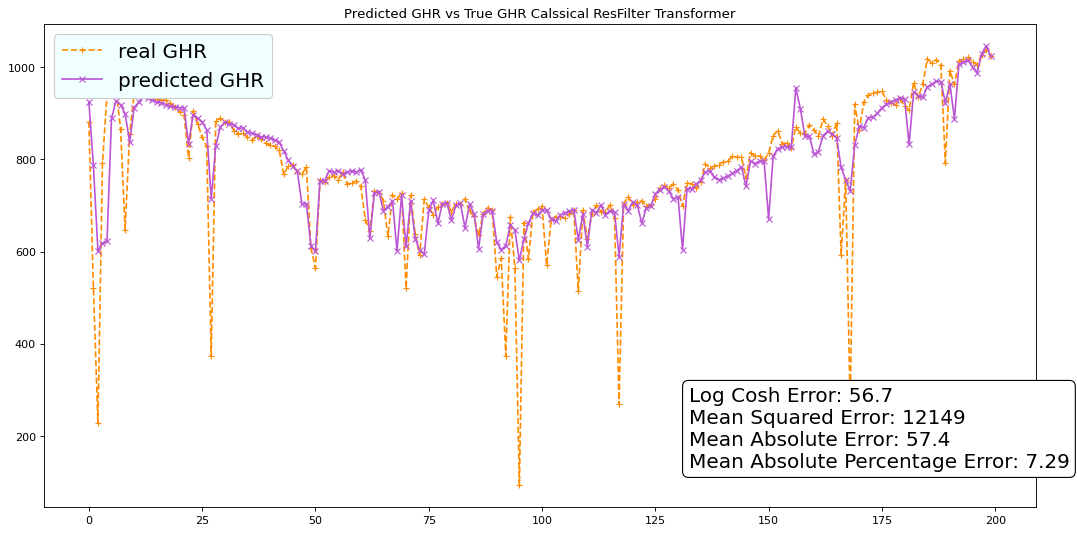

In [9]:
mse=tf.keras.metrics.MeanSquaredError()
mse.update_state(tf.reshape(predictions_0,(-1,)), tf.reshape(outputs_test,(-1,)))

mae= tf.keras.metrics.MeanAbsoluteError()
mae.update_state(tf.reshape(predictions_0,(-1,)), tf.reshape(outputs_test,(-1,)))

mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(tf.reshape(predictions_0,(-1,)), tf.reshape(outputs_test,(-1,)))

logcosh = tf.keras.metrics.LogCoshError()
logcosh.update_state(tf.reshape(predictions_0,(-1,)), tf.reshape(outputs_test,(-1,)))

logcosh=round(logcosh.result().numpy(),1)
mse=int(round(mse.result().numpy(),0))
mae=round(mae.result().numpy(),1)
mape=round(mape.result().numpy(),2)

print('**********************************************')
print('TESTING METRICS SCORES:')
print("Log Cosh Error: "+str(logcosh))
print("Mean Squared Error:" +str(mse)) 
print("Mean Absolute Error: " +str(mae))
print("Mean Absolute Percentage Error: " +str(mape)) 

print('**********************************************')


fig = figure(figsize=(16, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Predicted GHR vs True GHR Calssical ResFilter Transformer')
ax.plot(outputs_test[:200], label='real GHR', color='darkorange',ls='--', marker='+', markersize=6)
ax.plot(predictions_0[:200], label='predicted GHR', color='mediumorchid', marker='x', markersize=6)
ax.legend(framealpha=1.0, facecolor='azure' ,loc="upper left", fontsize=18)


textstr = '\n'.join((
    "Log Cosh Error: "+str(logcosh),
    "Mean Squared Error: " +str(mse),
    "Mean Absolute Error: " +str(mae),
    "Mean Absolute Percentage Error: " +str(mape)))

props = dict(boxstyle='round', facecolor='white', alpha=1,)

# place a text box in upper left in axes coords
ax.text(0.65, 0.250, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

#plt.show()
plt.savefig(save_fold+'test_classical_resfilter.png')

In [10]:

len_seq, input_dim=inputs_train.shape[-2:]
model_1=QEncoder_Only_Transformer(num_layers=4, 
                               d_attention=64, 
                               num_heads=4, 
                               len_seq=len_seq, 
                               input_dim=input_dim, 
                               dff=128, 
                               qubits=0,
                               pqc_layers=1,
                               qresfilter=True)

#optimizer
opt=tf.keras.optimizers.Adam(learning_rate=0.0003)

#early stopping callback
earstop=tf.keras.callbacks.EarlyStopping(patience=20,
    restore_best_weights=True)

#tracking callback
metrics=['mean_squared_error','mean_absolute_error', 'mean_absolute_percentage_error']
save_fold='/content/drive/MyDrive/TESI/ResFilterTransf_vs_QResFilterTransf/'
exp_name='quantum_res_transformer_direct'
tracking = Tracking(metrics,save_fold,exp_name,model_1)

model_1.compile(loss='log_cosh', optimizer=opt, metrics=metrics)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: UserWarning: 
NOTE: You are using an istance of the QuantumLayer2D class.
The maximum batch size dimension allowed in training/predicting for a model containing a QuantumLayer2D is 64.
When predicting outputs, please call the method call_in_batches of the model with a batch_size value less than or equal to 64.
If default call method is used when predicting and the batch size of the datas is greater than 64, an Error will be raised.
If a bigger batch size is desired, please consider to increase the value of max_batch_size arg in your QuantumLayer2D: quantum_layer_2d.


In [11]:
%%time
model_1.fit(inputs_train,outputs_train,batch_size=32,validation_split=0.2,epochs=200,callbacks=[tracking,earstop])

Epoch 1/200
43/43 [==============================] - 115s 2s/step - loss: 878.5853 - mean_squared_error: 809417.6250 - mean_absolute_error: 879.2785 - mean_absolute_percentage_error: 99.5955 - val_loss: 857.1814 - val_mean_squared_error: 773399.7500 - val_mean_absolute_error: 857.8746 - val_mean_absolute_percentage_error: 98.8890
Epoch 2/200
43/43 [==============================] - 76s 2s/step - loss: 864.9149 - mean_squared_error: 785630.3125 - mean_absolute_error: 865.6078 - mean_absolute_percentage_error: 97.9200 - val_loss: 836.3587 - val_mean_squared_error: 738113.6250 - val_mean_absolute_error: 837.0517 - val_mean_absolute_percentage_error: 96.3018
Epoch 3/200
43/43 [==============================] - 74s 2s/step - loss: 837.0600 - mean_squared_error: 738207.9375 - mean_absolute_error: 837.7534 - mean_absolute_percentage_error: 94.4990 - val_loss: 798.7070 - val_mean_squared_error: 676499.6875 - val_mean_absolute_error: 799.4001 - val_mean_absolute_percentage_error: 91.6245
Epoch 

Now make predictions: eventally here call the saved model from drive 

In [12]:
predictions_1=model_1.call_in_batches(inputs_test,batch_size=32)

**********************************************
TESTING METRICS SCORES:
Log Cosh Error: 90.9
Mean Squared Error:23173
Mean Absolute Error: 91.6
Mean Absolute Percentage Error: 10.66
**********************************************


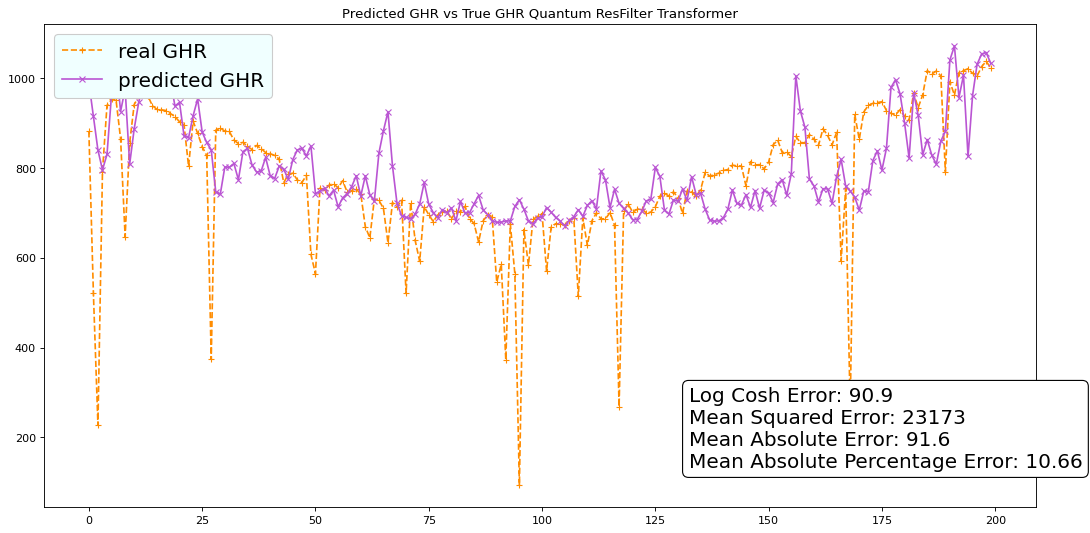

In [13]:
mse=tf.keras.metrics.MeanSquaredError()
mse.update_state(tf.reshape(predictions_1,(-1,)), tf.reshape(outputs_test,(-1,)))

mae= tf.keras.metrics.MeanAbsoluteError()
mae.update_state(tf.reshape(predictions_1,(-1,)), tf.reshape(outputs_test,(-1,)))

mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(tf.reshape(predictions_1,(-1,)), tf.reshape(outputs_test,(-1,)))

logcosh = tf.keras.metrics.LogCoshError()
logcosh.update_state(tf.reshape(predictions_1,(-1,)), tf.reshape(outputs_test,(-1,)))

logcosh=round(logcosh.result().numpy(),1)
mse=int(round(mse.result().numpy(),0))
mae=round(mae.result().numpy(),1)
mape=round(mape.result().numpy(),2)

print('**********************************************')
print('TESTING METRICS SCORES:')
print("Log Cosh Error: "+str(logcosh))
print("Mean Squared Error:" +str(mse)) 
print("Mean Absolute Error: " +str(mae))
print("Mean Absolute Percentage Error: " +str(mape)) 

print('**********************************************')


fig = figure(figsize=(16, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Predicted GHR vs True GHR Quantum ResFilter Transformer')
ax.plot(outputs_test[:200], label='real GHR', color='darkorange',ls='--', marker='+', markersize=6)
ax.plot(predictions_1[:200], label='predicted GHR', color='mediumorchid', marker='x', markersize=6)
ax.legend(framealpha=1.0, facecolor='azure' ,loc="upper left", fontsize=18)


textstr = '\n'.join((
    "Log Cosh Error: "+str(logcosh),
    "Mean Squared Error: " +str(mse),
    "Mean Absolute Error: " +str(mae),
    "Mean Absolute Percentage Error: " +str(mape)))

props = dict(boxstyle='round', facecolor='white', alpha=1,)

# place a text box in upper left in axes coords
ax.text(0.65, 0.250, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)


plt.savefig(save_fold+'test_quantum_restransformer_direct.png')

Classic, small filter dimension

In [20]:

len_seq, input_dim=inputs_train.shape[-2:]
model_2=Encoder_Only_Transformer(num_layers=4, 
                               d_attention=64, 
                               num_heads=4, 
                               len_seq=len_seq, 
                               input_dim=input_dim, 
                               dff=128, 
                               dim_filter=2,
                               resfilter=True)

#optimizer
opt=tf.keras.optimizers.Adam(learning_rate=0.0003)

#early stopping callback
earstop=tf.keras.callbacks.EarlyStopping(patience=20,
    restore_best_weights=True)

#tracking callback
metrics=['mean_squared_error','mean_absolute_error', 'mean_absolute_percentage_error']
save_fold='/content/drive/MyDrive/TESI/ResFilterTransf_vs_QResFilterTransf/'
exp_name='classical_res_transformer_small_filter'
tracking = Tracking(metrics,save_fold,exp_name,model_2)

model_2.compile(loss='log_cosh', optimizer=opt, metrics=metrics)

In [21]:
%%time
model_2.fit(inputs_train,outputs_train,batch_size=32,validation_split=0.2,epochs=200,callbacks=[tracking,earstop])

Epoch 1/200
43/43 [==============================] - 14s 82ms/step - loss: 871.5522 - mean_squared_error: 797117.7500 - mean_absolute_error: 872.2454 - mean_absolute_percentage_error: 98.7389 - val_loss: 840.3593 - val_mean_squared_error: 744794.0625 - val_mean_absolute_error: 841.0526 - val_mean_absolute_percentage_error: 96.8013
Epoch 2/200
43/43 [==============================] - 2s 43ms/step - loss: 838.8784 - mean_squared_error: 741287.3125 - mean_absolute_error: 839.5715 - mean_absolute_percentage_error: 94.7359 - val_loss: 795.3658 - val_mean_squared_error: 671162.5000 - val_mean_absolute_error: 796.0590 - val_mean_absolute_percentage_error: 91.2099
Epoch 3/200
43/43 [==============================] - 2s 46ms/step - loss: 780.8604 - mean_squared_error: 647544.1875 - mean_absolute_error: 781.5533 - mean_absolute_percentage_error: 87.6132 - val_loss: 717.4968 - val_mean_squared_error: 553265.6250 - val_mean_absolute_error: 718.1900 - val_mean_absolute_percentage_error: 81.5353
Epo

In [22]:
predictions_2=model_2.predict(inputs_test)

**********************************************
TESTING METRICS SCORES:
Log Cosh Error: 66.1
Mean Squared Error:16551
Mean Absolute Error: 66.8
Mean Absolute Percentage Error: 7.96
**********************************************


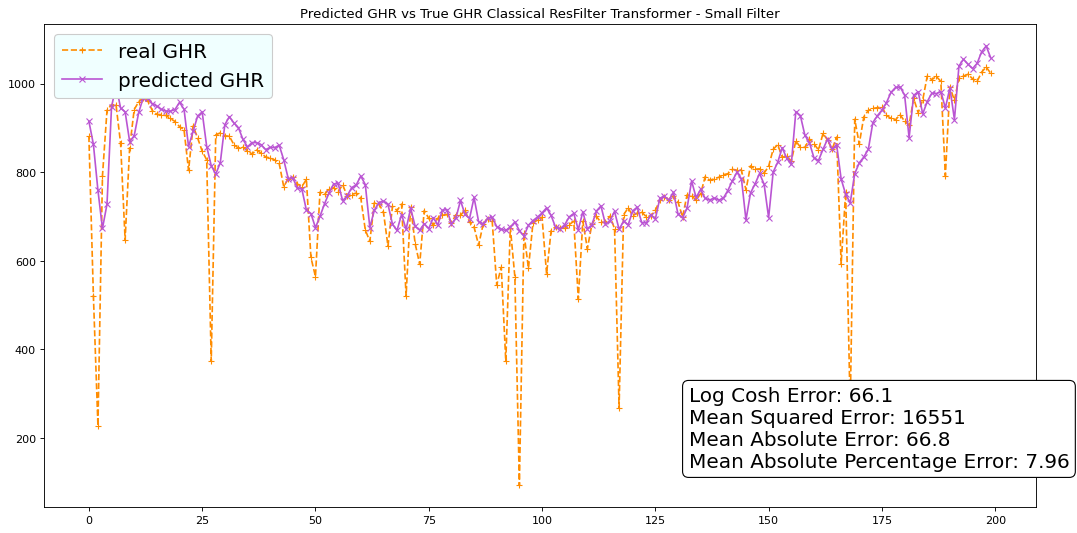

In [23]:
mse=tf.keras.metrics.MeanSquaredError()
mse.update_state(tf.reshape(predictions_2,(-1,)), tf.reshape(outputs_test,(-1,)))

mae= tf.keras.metrics.MeanAbsoluteError()
mae.update_state(tf.reshape(predictions_2,(-1,)), tf.reshape(outputs_test,(-1,)))

mape = tf.keras.metrics.MeanAbsolutePercentageError()
mape.update_state(tf.reshape(predictions_2,(-1,)), tf.reshape(outputs_test,(-1,)))

logcosh = tf.keras.metrics.LogCoshError()
logcosh.update_state(tf.reshape(predictions_2,(-1,)), tf.reshape(outputs_test,(-1,)))

logcosh=round(logcosh.result().numpy(),1)
mse=int(round(mse.result().numpy(),0))
mae=round(mae.result().numpy(),1)
mape=round(mape.result().numpy(),2)

print('**********************************************')
print('TESTING METRICS SCORES:')
print("Log Cosh Error: "+str(logcosh))
print("Mean Squared Error:" +str(mse)) 
print("Mean Absolute Error: " +str(mae))
print("Mean Absolute Percentage Error: " +str(mape)) 

print('**********************************************')


fig = figure(figsize=(16, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Predicted GHR vs True GHR Classical ResFilter Transformer - Small Filter')
ax.plot(outputs_test[:200], label='real GHR', color='darkorange',ls='--', marker='+', markersize=6)
ax.plot(predictions_2[:200], label='predicted GHR', color='mediumorchid', marker='x', markersize=6)
ax.legend(framealpha=1.0, facecolor='azure' ,loc="upper left", fontsize=18)


textstr = '\n'.join((
    "Log Cosh Error: "+str(logcosh),
    "Mean Squared Error: " +str(mse),
    "Mean Absolute Error: " +str(mae),
    "Mean Absolute Percentage Error: " +str(mape)))

props = dict(boxstyle='round', facecolor='white', alpha=1,)

# place a text box in upper left in axes coords
ax.text(0.65, 0.250, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

#plt.show()
plt.savefig(save_fold+'test_classical_resfilter_small.png')

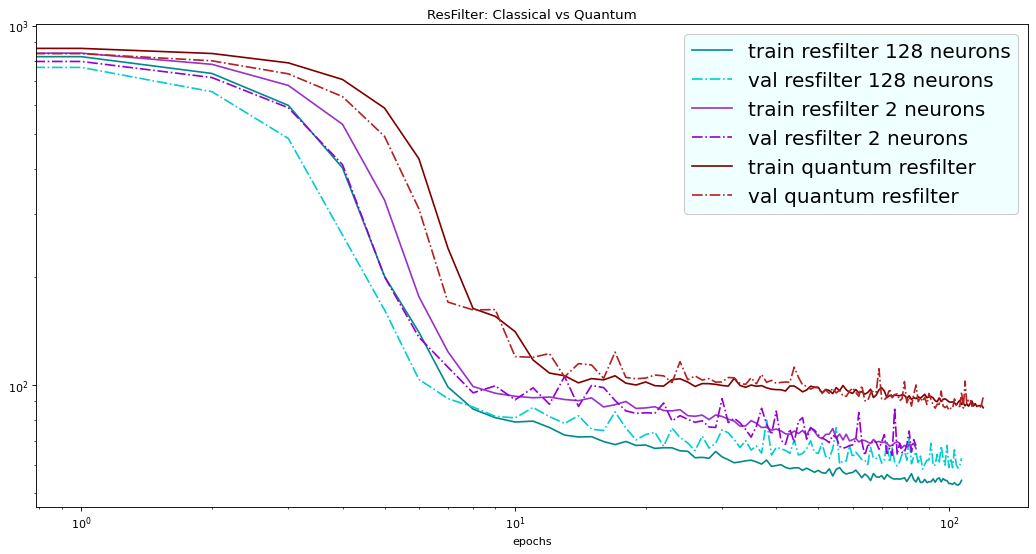

In [26]:
history_0=pd.read_csv(save_fold+'classical_res_transformer'+'_history.csv')
history_1=pd.read_csv(save_fold+'quantum_res_transformer_direct'+'_history.csv')
history_2=pd.read_csv(save_fold+'classical_res_transformer_small_filter'+'_history.csv')

loss_0=history_0['loss'].to_numpy()
val_loss_0=history_0['val_loss'].to_numpy()
loss_1=history_1['loss'].to_numpy()
val_loss_1=history_1['val_loss'].to_numpy()
loss_2=history_2['loss'].to_numpy()
val_loss_2=history_2['val_loss'].to_numpy()

fig=figure(figsize=(16, 8), dpi=80)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('ResFilter: Classical vs Quantum')

ax.plot(loss_0, label='train resfilter 128 neurons', c='darkcyan')
ax.plot(val_loss_0, label='val resfilter 128 neurons', c='darkturquoise', ls='dashdot')

ax.plot(loss_2, label='train resfilter 2 neurons', c='darkorchid')
ax.plot(val_loss_2, label='val resfilter 2 neurons', c='darkviolet', ls='dashdot')

ax.plot(loss_1, label='train quantum resfilter',  c='maroon' )
ax.plot(val_loss_1, label='val quantum resfilter', c='firebrick', ls='dashdot')



ax.legend(framealpha=1.0, facecolor='azure' ,loc="upper right", fontsize=18)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('epochs')


plt.savefig(save_fold+'losses_comparison.png')